# `scikit-learn`__-style API__

In this notebook, we give an overview of using our user-friendly `scikit-learn`-style API.
Oftentimes, existing data analysis pipelines assume `scikit-learn` API for the models,
so it is useful to prepare an `adelie` solver obeying such an API for seamless integration.
Our `scikit-learn`-style solver is a simple wrapper of the more generic tools provided in `adelie`.
Consequently, it is slightly less flexible (e.g., cannot supply a user-specified GLM).
However, it provides many commonly used functionalities 
to serve as a quick drop-in replacement for many existing solvers in `scikit-learn` with `adelie`.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import (
    load_breast_cancer,
    load_diabetes,
    load_digits,
)
from sklearn.preprocessing import OneHotEncoder
import adelie as ad
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

np.random.seed(42)

## __Regression__

We load the `diabetes` dataset as a regression example and perform a train-test split.
Note that we change the storage type for $X$ to be Fortran-order (column-major) 
since it is more efficient for our solver.

In [2]:
data = load_diabetes()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.asfortranarray(X_train)
X_test = np.asfortranarray(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((353, 10), (353,), (89, 10), (89,))

We check that the train and test responses are similar in distribution.

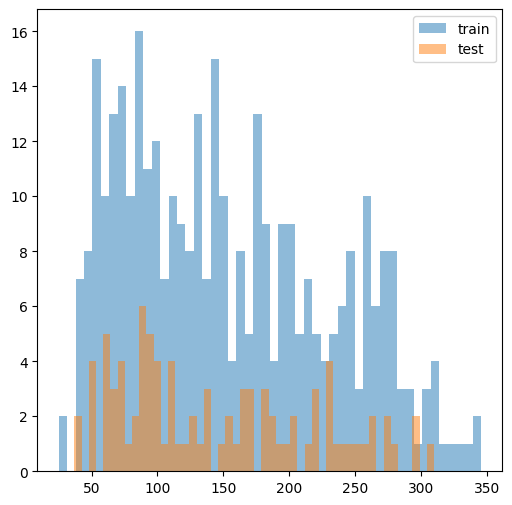

In [3]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist(y_train, bins=50, alpha=0.5, label='train')
ax.hist(y_test, bins=50, alpha=0.5, label='test')
ax.legend()
plt.show()

### __Lasso__

We first instantiate our `scikit-learn`-style solver class `GroupElasticNet`.
We will use the default setting, which solves the lasso problem with Gaussian loss.
As usual, we call `fit()` with our training data `X_train` and `y_train` to solve 
the lasso along a path of regularization values $\lambda$.

In [4]:
model_gaussian = ad.GroupElasticNet()
model_gaussian.fit(X_train, y_train)

100%|██████████| 100/100 [00:00:00<00:00:00, 2392.51it/s] [dev:52.5%]


GroupElasticNet()

We call `predict()` to compute the linear predictions for each $\lambda$ (each row).

In [5]:
yhatmat = model_gaussian.predict(X_test)  
yhatmat.shape

(100, 89)

Next, we compute the out-of-sample $R^2$ for each $\lambda$ value.

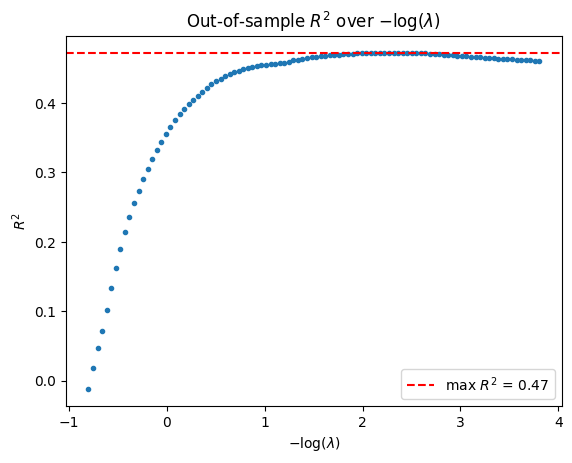

In [6]:
r2vec = np.apply_along_axis(lambda yhat: r2_score(y_test, yhat), axis=1, arr=yhatmat)
lam_path = model_gaussian.lambda_
plt.plot(-np.log(lam_path), r2vec, linestyle="None", marker=".")
plt.axhline(r2vec.max(), color="red", linestyle="--", label=f"max $R^2$ = {r2vec.max():.2f}")
plt.title(r"Out-of-sample $R^2$ over $-\log(\lambda)$")
plt.xlabel(r"$-\log(\lambda$)")
plt.ylabel(r"$R^2$")
plt.legend()
plt.show()

### __K-Fold Cross-Validation__

More often, the user wishes to perform model selection via cross-validation before deploying a model.
If the model class is initalized with the `"cv_grpnet"` solver, 
we select the best $\lambda$ by cross-validation and return the model at that $\lambda$.

In [7]:
model_cv_gaussian = ad.GroupElasticNet(solver="cv_grpnet")
model_cv_gaussian.fit(X_train, y_train, min_ratio=1e-3)

100%|██████████| 100/100 [00:00:00<00:00:00, 43455.42it/s] [dev:52.6%]


GroupElasticNet(solver='cv_grpnet')

With the `cv_grpnet` backend, calling predict automatically uses the model with the best $\lambda$.

In [8]:
model_cv_gaussian.predict(X_test).shape

(89,)

The class also has a score method that computes $R^2$. 

In [9]:
model_cv_gaussian.score(X_test, y_test)

0.45673736460682524

## __Binary Classification__

### __Logistic Regression__

We load the `breast_cancer` dataset as a binary classification example and perform a train-test split.

In [10]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.asfortranarray(X_train)
X_test = np.asfortranarray(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((455, 30), (455,), (114, 30), (114,))

Since we have a binary classification task, we specify our solver to use the `"binomial"` family for our response.
We fit using our cross-validation solver as before.

In [11]:
model_cv_binomial = ad.GroupElasticNet(solver="cv_grpnet", family="binomial")
model_cv_binomial.fit(
    X_train, 
    y_train.astype(np.float64),
)

100%|██████████| 100/100 [00:00:00<00:00:00, 41538.31it/s] [dev:63.3%]


GroupElasticNet(family='binomial', solver='cv_grpnet')

For the `"binomial"` family, the predict method outputs
the class label predictions based on the probability estimates.
Once we have our class predictions, we can output a contingency table.
Here, we see that we never mispredict when the test $y_i = 1$, but have 16 mispredictions when $y_i = 0$.

In [12]:
yhat = model_cv_binomial.predict(X_test)
st.contingency.crosstab(y_test, yhat).count

array([[28, 16],
       [ 0, 70]])

We can compute the probability estimates at the test points and plot the frequency.

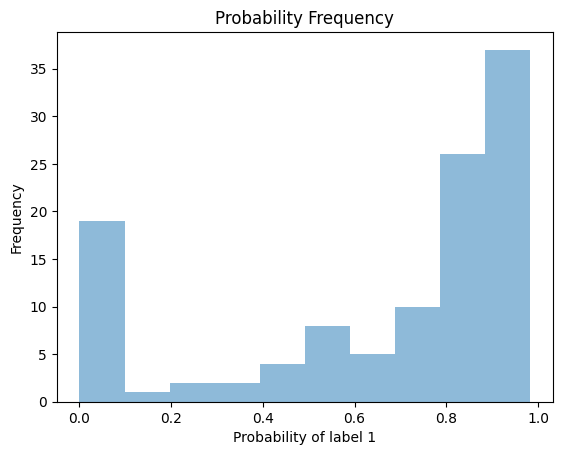

In [13]:
plt.hist(model_cv_binomial.predict_proba(X_test)[:, 1], alpha = 0.5)
plt.xlabel("Probability of label 1")
plt.ylabel("Frequency")
plt.title("Probability Frequency")
plt.show()

## __Multi-Class Classification__

### __Multinomial Regression__

We load the `digits` dataset as a multi-class classification example and perform a train-test split.

In [14]:
data = load_digits()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = np.asfortranarray(X_train)
X_test = np.asfortranarray(X_test)
# one-hot-encode labels
oh = OneHotEncoder(sparse_output=False)
y_train2 = oh.fit_transform(y_train[:, np.newaxis])
X_train.shape, y_train.shape, y_train2.shape, X_test.shape, y_test.shape

((1437, 64), (1437,), (1437, 10), (360, 64), (360,))

Since we have a multi-class classification task, 
we specify our solver to use the `"multinomial"` family for our response.
We fit using our cross-validation solver as before.

In [18]:
model_cv_multinomial = ad.GroupElasticNet(solver="cv_grpnet", family="multinomial")
model_cv_multinomial.fit(
    X_train, 
    y_train2.astype(np.float64),
)

100%|██████████| 100/100 [00:00:01<00:00:00, 75.64it/s] [dev:84.7%]


GroupElasticNet(family='multinomial', solver='cv_grpnet')

For the `"multinomial"` family, the predict method outputs
the class label predictions based on the probability estimates just like the `"binomial"` family.
Once we have our class predictions, we can output a contingency table.

In [19]:
yhat = model_cv_multinomial.predict(X_test)
st.contingency.crosstab(y_test, yhat).count

array([[29,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 32,  0,  0,  0,  0,  0,  0,  2,  2],
       [ 0,  0, 41,  1,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0, 34,  0,  0,  0,  0,  1,  0],
       [ 0,  1,  0,  0, 37,  0,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  0, 37,  0,  0,  0,  3],
       [ 0,  1,  0,  0,  0,  0, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 31,  0,  0],
       [ 0,  3,  0,  1,  0,  2,  0,  2, 23,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0, 34]])